# Wildfire trends in California

In [26]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
import jenkspy
import altair_latimes as lat
import altair as alt
alt.renderers.enable('notebook')
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.float_format = '{:,.0f}'.format

In [27]:
# processed @ wildfires/00_cleaning.ipynb
wildfires = gpd.read_file('/Users/mhustiles/data/data/GIS/wildfires/FRAP/output/wildfires.geojson')

In [28]:
wildfires['alarm_date'] = wildfires['alarm_date'].str.replace('T00:00:00', '')
wildfires['year_'] = wildfires['year_'].astype(int)

In [29]:
wildfires.columns

Index(['objectid', 'year_', 'state', 'agency', 'unit_id', 'fire_name',
       'inc_num', 'alarm_date', 'cont_date', 'cause', 'comments', 'report_ac',
       'gis_acres', 'c_method', 'objective', 'fire_num', 'sqmiles',
       'alarm_year', 'alarm_quarter', 'alarm_day', 'alarm_month',
       'alarm_monthname', 'cause_description', 'agency_description',
       'unit_description', 'fire', 'geometry'],
      dtype='object')

In [30]:
wildfires.head()

,objectid,year_,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,cause,...,alarm_year,alarm_quarter,alarm_day,alarm_month,alarm_monthname,cause_description,agency_description,unit_description,fire,geometry
0,1,2007,CA,CCO,LAC,OCTOBER,00246393,2007-10-21,2007-10-23,14,...,2007,4,21,10,October,Unknown/Unidentified,Contract Counties,Los Angeles County,October,(POLYGON ((-118.4985124819225 34.3824189370447...
1,2,2007,CA,CCO,LAC,MAGIC,00233077,2007-10-22,2007-10-25,14,...,2007,4,22,10,October,Unknown/Unidentified,Contract Counties,Los Angeles County,Magic,(POLYGON ((-118.5844782794717 34.4197766738174...
2,3,2007,CA,USF,ANF,RANCH,00000166,2007-10-20,2007-11-15,2,...,2007,4,20,10,October,Equipment Use,United States Forest Service,Angeles National Forest,Ranch,(POLYGON ((-118.7564468802518 34.5965130520924...
3,4,2007,CA,CCO,LAC,EMMA,00201384,2007-09-11,2007-09-11,14,...,2007,3,11,9,September,Unknown/Unidentified,Contract Counties,Los Angeles County,Emma,(POLYGON ((-118.0727716195954 34.5019812566583...
4,5,2007,CA,CCO,LAC,CORRAL,00259483,2007-11-24,2007-11-27,14,...,2007,4,24,11,November,Unknown/Unidentified,Contract Counties,Los Angeles County,Corral,(POLYGON ((-118.7440804532698 34.0812976688129...


---

In [55]:
result_decade = []

for value in wildfires['year_']: 
    if value > 1979 and value < 1990: 
        result_decade.append('1980s')
    elif value > 1989 and value < 2000: 
        result_decade.append('1990s')
    elif value > 1999 and value < 2010: 
        result_decade.append('2000s')
    else: 
        result_decade.append('2010s')
    
wildfires['decade'] = result_decade

In [56]:
result = []

for value in wildfires['year_']: 
    if value > 1979 and value < 1985: 
        result.append('1980-84')
    elif value > 1984 and value < 1990: 
        result.append('1985-89')
    elif value > 1989 and value < 1995: 
        result.append('1990-94')
    elif value > 1994 and value < 2000: 
        result.append('1995-99')
    elif value > 1999 and value < 2005: 
        result.append('2000-04')
    elif value > 2004 and value < 2010: 
        result.append('2005-09') 
    elif value > 2009 and value < 2015: 
        result.append('2010-14')
    else: 
        result.append('2015-18')
    
wildfires['half_decade'] = result

In [94]:
large_fires_decades = wildfires[wildfires['gis_acres'] > 5000].groupby(['decade'])\
    .agg({'gis_acres': [("sum", "sum"), ("count", "count")]}).reset_index().round()
large_fires_decades.columns = ["_".join(x) for x in large_fires_decades.columns.ravel()]

In [95]:
large_fires_years = wildfires[wildfires['gis_acres'] > 5000].groupby(['year_'])\
    .agg({'gis_acres': [("sum", "sum"), ("count", "count")]}).reset_index().round()
large_fires_years.columns = ["_".join(x) for x in large_fires_years.columns.ravel()]

In [96]:
large_fires_years.head(10)

,year__,gis_acres_sum,gis_acres_count
0,1980,"213,602",15
1,1981,"175,614",14
2,1982,"77,260",4
3,1983,"9,310",1
4,1984,"105,505",10
5,1985,"444,280",15
6,1986,"39,247",4
7,1987,"696,432",36
8,1988,"172,770",15
9,1989,"66,973",6


In [97]:
large_fires_decades.head(10)

,decade_,gis_acres_sum,gis_acres_count
0,1980s,"2,000,994",120
1,1990s,"2,342,828",116
2,2000s,"5,502,221",190
3,2010s,"5,912,600",167


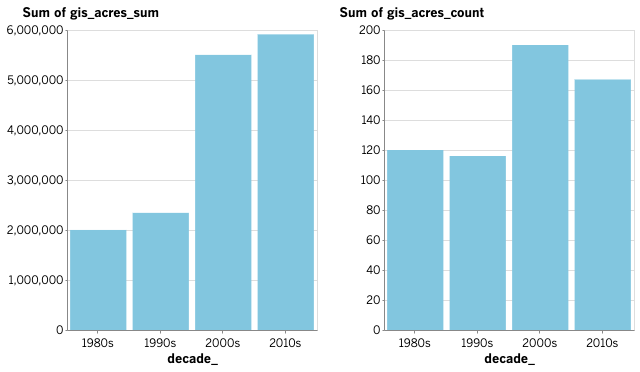

In [98]:
acres = alt.Chart(large_fires_decades).mark_bar().encode(
    x='decade_:O',
    y='sum(gis_acres_sum):Q'
).properties(height=300, width=250)

count = alt.Chart(large_fires_decades).mark_bar().encode(
    x='decade_:O',
    y='sum(gis_acres_count):Q'
).properties(height=300, width=250)

acres|count

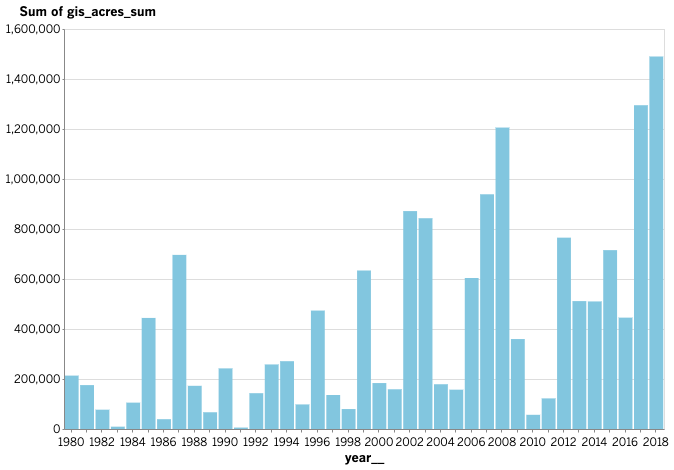

In [99]:
acres_years = alt.Chart(large_fires_years).mark_bar().encode(
    x='year__:O',
    y='sum(gis_acres_sum):Q'
).properties(height=400, width=600)

acres_years

### Export for years summary table

In [103]:
large_fires_years.to_csv('output/large_fires_years.csv')

### Add CA counties

In [13]:
counties = gpd.read_file('http://s3-us-west-2.amazonaws.com/boundaries.\
latimes.com/archive/1.0/boundary-set/counties-2012.geojson')

In [14]:
## corresponds to census 'consolidated statistical area' 
la_csa = counties[(counties['name'] == 'Los Angeles') \
                   | (counties['name'] == 'Orange') \
                   | (counties['name'] == 'Ventura') \
                   | (counties['name'] == 'San Bernardino')\
                   | (counties['name'] == 'Riverside')]

In [15]:
## corresponds to census 'consolidated statistical area' 
la_county = counties[(counties['name'] == 'Los Angeles')]

In [16]:
la_area_fires = gpd.sjoin(wildfires, la_csa, op='within')
la_county_fires = gpd.sjoin(wildfires, la_county, op='intersects')

In [17]:
len(la_county_fires)

999

In [18]:
len(la_area_fires)

2147

In [19]:
len(wildfires)

9643

In [20]:
la_area_fires_lg = la_area_fires[la_area_fires['gis_acres'] > 1000 ]
la_county_fires_lg = la_county_fires[la_county_fires['gis_acres'] > 1000 ]

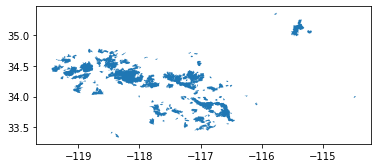

In [21]:
la_area_fires_lg.plot()

In [22]:
la_area_fires_lg.to_file('/Users/mhustiles/data/data/GIS/\
wildfires/FRAP/output/la_county_fires_lg.geojson', driver='GeoJSON')